In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn import metrics
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import models
import torch.optim as optim
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from collections import OrderedDict

In [2]:
# Set based on whether running locally or on colab
COLAB = True

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/data/mnm2_processed_data_slices.zip"

Streaming output truncated to the last 5000 lines.
  inflating: mnm2_processed_data_slices/train/images/041_SA_ES_0006.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._041_SA_ES_0006.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/083_SA_ES_0009.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._083_SA_ES_0009.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/054_SA_ED_0000.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._054_SA_ED_0000.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/098_SA_ES_0003.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._098_SA_ES_0003.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/019_SA_ES_0007.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._019_SA_ES_0007.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/067_SA_ED_0006.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slice

In [5]:
data_folder = '/content/mnm2_processed_data_slices/'

#### Create Dataset

In [6]:
class MnM2Dataset(Dataset):
    def __init__(self, root_dir, train=False, test=False, transform=None, remove_no_mask=False):
        super().__init__()
        self.root_dir = root_dir
        self.train=train
        self.test=test
        self.transform = transform
        self.remove_no_mask = remove_no_mask

        if self.train:
            self.image_dir = self.root_dir + 'train/images/'
            self.label_dir = self.root_dir + 'train/labels/'
        elif self.test:
            self.image_dir = self.root_dir + 'test/images/'
            self.label_dir = self.root_dir + 'test/labels/'
        else:
            self.image_dir = self.root_dir + 'valid/images/'
            self.label_dir = self.root_dir + 'valid/labels/'

        self.image_files = sorted([f for f in os.listdir(self.image_dir)])
        self.label_files = sorted([f for f in os.listdir(self.label_dir)])

        if remove_no_mask:
            self.filtered_files = self.filter_images_with_masks()
        else:
            self.filtered_files = list(range(len(self.image_files)))

    def __len__(self):
        return len(self.filtered_files)

    def __getitem__(self, index):
        filtered_index = self.filtered_files[index]
        #print(f"Index: {index}, Actual Index: {filtered_index}, Type of actual_idx: {type(filtered_index)}")

        image_path = os.path.join(self.image_dir, self.image_files[filtered_index])
        label_path = os.path.join(self.label_dir, self.label_files[filtered_index])
        image = nib.load(image_path).get_fdata().astype(np.float32)
        label = nib.load(label_path).get_fdata().astype(np.float32)
        label = np.where(label == 3, 1.0, 0.0).astype(np.float32) # keep label=3 (RV) only
        '''
        image = transforms.ToPILImage()(image)
        image = transforms.Resize((256, 256))(image)
        image = transforms.ToTensor()(image)
        label = transforms.ToPILImage()(label)
        label = transforms.Resize((256, 256))(label)
        label = transforms.ToTensor()(label)
        '''

        image = image/(image.max()/255.0)
        image = image.astype(np.uint8)

        image = transforms.ToTensor()(image)
        label = transforms.ToTensor()(label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

    def filter_images_with_masks(self):
        index_with_masks = []
        for idx, label_file in enumerate(self.label_files):
            label_path = os.path.join(self.label_dir, label_file)
            label = nib.load(label_path).get_fdata().astype(np.float32)
            label = np.where(label == 3, 1.0, 0.0).astype(np.float32) # keep label=3 (RV) only

            if np.any(label > 0): index_with_masks.append(idx)

        return index_with_masks

#### Model

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=64):
        super(UNet, self).__init__()

        features = init_features

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.conv(dec1)

        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True))

                ]
            )
        )

#### Evaluation

In [8]:
def dice_coefficient(pred_mask, mask):
  with torch.no_grad():
        pred_mask = torch.sigmoid(pred_mask)
        #pred_mask = pred_mask[pred_mask > 0.5].float()
        pred_mask[pred_mask<=0.5] = 0
        pred_mask[pred_mask>0.5] = 1

        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        #print('label',true_label)
        intersect = float(torch.sum(pred_mask * mask).item())
        union = float(torch.sum(pred_mask).item() + torch.sum(mask).item())
        if union==0:
          dice=0
        else: dice = (2.0 * intersect) / union
        return dice

In [9]:
model_name = 'unet'

In [10]:
directory='./data/mnm2_processed_data_slices/' #directory to the data
checkpoint_dir='./checkpoints' #directory to the data
tb_logs_dir = './runs' # tensorboard logs

if COLAB:
    directory='./mnm2_processed_data_slices/' #directory to the data
    checkpoint_dir='./gdrive/MyDrive/Colab Notebooks/mnm2 segmentation/checkpoints_no aug' #directory to the data
    tb_logs_dir = './gdrive/MyDrive/Colab Notebooks/mnm2 segmentation/runs' # tensorboard logs

#lr = 1e-3 #learning rate
#num_epochs = 20 # number of epochs
batch_size = 1 # batch size

In [11]:
model_test = UNet()

# load model from checkpoints
which_epoch = 16
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_{}_epoch_{}".format(model_name, which_epoch))

if torch.cuda.is_available():
  model_state = torch.load(checkpoint_path)
else:
  model_state = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model_test.load_state_dict(model_state)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model_test.to(device)

<ipython-input-11-5508b2f735e2>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(checkpoint_path)


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model_test.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Trainable Paramters: {params}')

params_all = sum([np.prod(p.size()) for p in model_test.parameters()])
print(f'All Paramters: {params_all}')

Trainable Paramters: 31036481
All Paramters: 31036481


In [13]:
valid_transform = transforms.Compose([
    #transforms.ToTensor(),
    transforms.CenterCrop(256)
])

#initialise the test datasets (class we defined earlier) and then initialise a Pytorch's dataloader
test_dataset = MnM2Dataset(directory, test=True, transform = valid_transform, remove_no_mask=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

In [14]:
with torch.no_grad(): # to prevent cuda out of memory
  _ = model_test.eval()
  test_dscs = []

  print('Running testing..')
  with tqdm(total=len(test_loader)) as pbar:
          for i, (image, label) in enumerate(test_loader):
              image = image.to(device)
              label = label.to(device)

              prediction = model_test.forward(image)

              dsc = dice_coefficient(prediction, label)
              test_dscs.append(dsc)

              pbar.update(1)

Running testing..


100%|██████████| 1052/1052 [00:29<00:00, 35.83it/s]


In [15]:
#arr = np.array([t.detach().cpu().numpy() for t in test_dscs])
np.mean(test_dscs)

0.7483612245640957

Text(0.5, 1.0, 'DSC: 0.0')

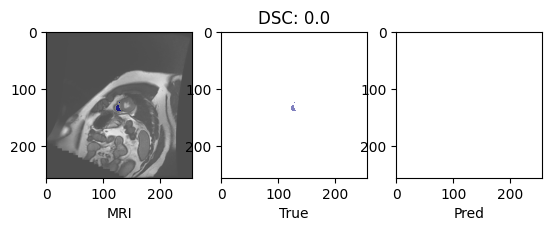

In [16]:
# get an example
data_iter = iter(test_loader)
(image, label) = next(data_iter)


img = image.squeeze(0).permute((1, 2, 0)).contiguous()
lab = label.squeeze(0).permute((1, 2, 0)).contiguous()

image = image.to(device)
label = label.to(device)
prediction = model_test.forward(image)

pred_mask = torch.sigmoid(prediction)
pred_mask[pred_mask<=0.5] = 0
pred_mask[pred_mask>0.5] = 1

pred_dsc = dice_coefficient(pred_mask, label)

# remove background
lab_plt = lab.numpy().copy()
pred_mask_plt = pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy().copy()

lab_plt[lab_plt==0] = np.nan
pred_mask_plt[pred_mask_plt==0] = np.nan

# Plot the image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img, cmap='gray', alpha=0.7)
ax1.imshow(lab_plt, cmap='jet', alpha=0.8)
ax1.imshow(pred_mask_plt, cmap='ocean', alpha=0.8)
ax2.imshow(lab_plt, cmap='jet', alpha = 0.5)
ax3.imshow(pred_mask_plt, cmap='ocean', alpha = 0.5)
#ax3.imshow(lab, cmap='jet', alpha = 0.5)
ax1.set_xlabel('MRI')
ax2.set_xlabel('True')
ax3.set_xlabel('Pred')
ax2.set_title('DSC: {}'.format(round(pred_dsc, 3)))

In [17]:
class MnM2Check(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        super().__init__()
        self.dir = dir
        self.transform = transform
        self.image_dir = image_dir
        self.label_dir = label_dir



    def __len__(self):
        return 1

    def __getitem__(self, index):
        image = nib.load(self.image_dir).get_fdata().astype(np.float32)
        label = nib.load(self.label_dir).get_fdata().astype(np.float32)
        label = np.where(label == 3, 1.0, 0.0).astype(np.float32) # keep label=3 (RV) only

        image = image/(image.max()/255.0)
        image = image.astype(np.uint8)

        image = transforms.ToTensor()(image)
        label = transforms.ToTensor()(label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

In [18]:
image_path = '/content/mnm2_processed_data_slices/test/images/259_SA_ES_0006.nii.gz'
label_path = '/content/mnm2_processed_data_slices/test/labels/259_SA_ES_gt_0006.nii.gz'
check_image = MnM2Check(image_path, label_path, transform = valid_transform)

check_loader = torch.utils.data.DataLoader(
    check_image, batch_size=batch_size, shuffle=True, drop_last=False)

Text(0.5, 1.0, 'DSC: 0.289')

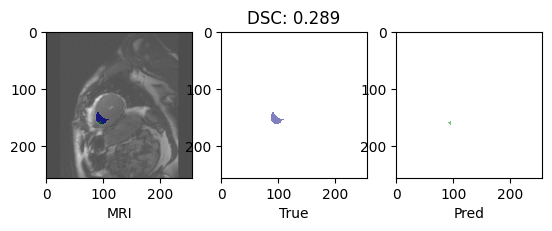

In [19]:
# get an example
data_iter = iter(check_loader)
(image, label) = next(data_iter)


img = image.squeeze(0).permute((1, 2, 0)).contiguous()
lab = label.squeeze(0).permute((1, 2, 0)).contiguous()

image = image.to(device)
label = label.to(device)
prediction = model_test.forward(image)

pred_mask = torch.sigmoid(prediction)
pred_mask[pred_mask<=0.5] = 0
pred_mask[pred_mask>0.5] = 1

pred_dsc = dice_coefficient(pred_mask, label)

# remove background
lab_plt = lab.numpy().copy()
pred_mask_plt = pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy().copy()

lab_plt[lab_plt==0] = np.nan
pred_mask_plt[pred_mask_plt==0] = np.nan

# Plot the image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img, cmap='gray', alpha=0.7)
ax1.imshow(lab_plt, cmap='jet', alpha=0.8)
ax1.imshow(pred_mask_plt, cmap='ocean', alpha=0.8)
ax2.imshow(lab_plt, cmap='jet', alpha = 0.5)
ax3.imshow(pred_mask_plt, cmap='ocean', alpha = 0.5)
#ax3.imshow(lab, cmap='jet', alpha = 0.5)
ax1.set_xlabel('MRI')
ax2.set_xlabel('True')
ax3.set_xlabel('Pred')
ax2.set_title('DSC: {}'.format(round(pred_dsc, 3)))